In [2]:
# Setup environment
%run 0-Environment_Setup.ipynb

sagemaker.config INFO - Not applying SDK defaults from location: /etc/xdg/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /root/.config/sagemaker/config.yaml
Stored 's3_datalake_path_csv' (str)
Stored 'local_data_path_csv' (str)
Stored 's3_datalake_path_parquet' (str)


In [3]:
import tensorflow as tf
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Input, Reshape, Normalization, Flatten, Dropout 
from tensorflow.keras.layers import Concatenate, GaussianNoise, Lambda
from tensorflow.keras.layers import Dense, LSTM, TimeDistributed, RNN, GRU, Conv1D, MaxPooling1D
from sklearn import preprocessing
from sklearn.metrics import mean_absolute_error, root_mean_squared_error

2024-10-14 16:30:00.186297: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-10-14 16:30:00.188546: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-10-14 16:30:00.191817: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-10-14 16:30:00.201820: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-10-14 16:30:00.221059: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been 

In [ ]:
# Import model card libraries
from sagemaker.model_card import (
    ModelCard,
    ModelOverview,
    ObjectiveFunction,
    Function,
    TrainingDetails,
    TrainingJobDetails,
    IntendedUses,
    BusinessDetails,
    EvaluationJob,
    AdditionalInformation,
    Metric,
    MetricGroup,
    ModelCardStatusEnum,
    ObjectiveFunctionEnum,
    FacetEnum,
    RiskRatingEnum,
    MetricTypeEnum,
    EvaluationMetricTypeEnum,
    HyperParameter
)

In [4]:
# Create a temporary directory for saving data
local_path = f"{os.getcwd()}/tmp"
if not os.path.exists(local_path):
    os.makedirs(local_path)

In [5]:
# Set session variables
from sagemaker.tensorflow import TensorFlow

sagemaker_session = sagemaker.Session()
role = sagemaker.get_execution_role()
region = sagemaker_session.boto_session.region_name
bucket = sess.default_bucket()

train_prefix = "store-sales-forecasting/train"
test_prefix = "store-sales-forecasting/test"
val_prefix = "store-sales-forecasting/val"

In [6]:
# Load data splits for testing in notebook
sagemaker_session.download_data(path=local_path, bucket=bucket, key_prefix=train_prefix)
sagemaker_session.download_data(path=local_path, bucket=bucket, key_prefix=test_prefix)
sagemaker_session.download_data(path=local_path, bucket=bucket, key_prefix=val_prefix)

continuous_train_inputs = np.load(os.path.join(local_path, 'continuous_train_inputs.npy'))
categorical_train_inputs = np.load(os.path.join(local_path, 'categorical_train_inputs.npy'))
train_targets = np.load(os.path.join(local_path, 'train_targets.npy'))

continuous_test_inputs = np.load(os.path.join(local_path, 'continuous_test_inputs.npy'))
categorical_test_inputs = np.load(os.path.join(local_path, 'categorical_test_inputs.npy'))
test_targets = np.load(os.path.join(local_path, 'test_targets.npy'))

continuous_val_inputs = np.load(os.path.join(local_path, 'continuous_val_inputs.npy'))
categorical_val_inputs = np.load(os.path.join(local_path, 'categorical_val_inputs.npy'))
val_targets = np.load(os.path.join(local_path, 'val_targets.npy'))

global_mean = np.load(os.path.join(local_path, 'global_mean.npy'))
global_stddev = np.load(os.path.join(local_path, 'global_stddev.npy'))

print(continuous_train_inputs.shape)
print(categorical_train_inputs.shape)
print(train_targets.shape)
print(continuous_test_inputs.shape)
print(categorical_test_inputs.shape)
print(test_targets.shape)
print(continuous_val_inputs.shape)
print(categorical_val_inputs.shape)
print(val_targets.shape)
print(global_mean)
print(global_stddev)

(1340, 54, 7, 3)
(1340, 54, 7, 15)
(1340, 54, 1)
(161, 54, 7, 3)
(161, 54, 7, 15)
(161, 54, 1)
(162, 54, 7, 3)
(162, 54, 7, 15)
(162, 54, 1)
[11066.08424029    72.62890566    23.37328494]
[9928.63142484   26.6484683    43.2551771 ]


I0000 00:00:1728879796.890399      19 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-10-14 04:23:16.892652: W tensorflow/core/common_runtime/gpu/gpu_device.cc:2343] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ continuous_input    │ (None, 54, 7, 3)  │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ gaussian_noise      │ (None, 54, 7, 3)  │          0 │ continuous_input… │
│ (GaussianNoise)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ categorical_input   │ (None, 54, 7, 15) │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 54, 7, 18) │          0 │ gaussian_noise[0… │
│ (Concatenate)       │                   │            │ categorical_inpu… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ reshape (Reshape)   │ (None, 378, 18)   │          0 │ concatenate[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm (LSTM)         │ (None, 8)         │        864 │ reshape[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 8)         │          0 │ lstm[0][0]        │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 54)        │        486 │ dropout[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ reshape_1 (Reshape) │ (None, 54, 1)     │          0 │ dense[0][0]       │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 1,350 (5.27 KB)

 Trainable params: 1,350 (5.27 KB)

 Non-trainable params: 0 (0.00 B)

None
Epoch 1/50


/opt/conda/lib/python3.10/site-packages/keras/src/models/functional.py:225: UserWarning: The structure of `inputs` doesn't match the expected structure: ['continuous_input', 'categorical_input']. Received: the structure of inputs=('*', '*')
  warnings.warn(


134/134 ━━━━━━━━━━━━━━━━━━━━ 7s 39ms/step - loss: 0.9294 - mean_absolute_error: 0.6083 - root_mean_squared_error: 0.9439 - val_loss: 0.7767 - val_mean_absolute_error: 0.5284 - val_root_mean_squared_error: 0.8739
Epoch 2/50
134/134 ━━━━━━━━━━━━━━━━━━━━ 5s 37ms/step - loss: 0.3831 - mean_absolute_error: 0.3743 - root_mean_squared_error: 0.6083 - val_loss: 0.5240 - val_mean_absolute_error: 0.4136 - val_root_mean_squared_error: 0.7162
Epoch 3/50
134/134 ━━━━━━━━━━━━━━━━━━━━ 5s 37ms/step - loss: 0.3603 - mean_absolute_error: 0.3260 - root_mean_squared_error: 0.5891 - val_loss: 0.4967 - val_mean_absolute_error: 0.4009 - val_root_mean_squared_error: 0.6970
Epoch 4/50
134/134 ━━━━━━━━━━━━━━━━━━━━ 5s 39ms/step - loss: 0.2723 - mean_absolute_error: 0.3008 - root_mean_squared_error: 0.5103 - val_loss: 0.4305 - val_mean_absolute_error: 0.3710 - val_root_mean_squared_error: 0.6475
Epoch 5/50
134/134 ━━━━━━━━━━━━━━━━━━━━ 5s 37ms/step - loss: 0.2708 - mean_absolute_error: 0.2997 - root_mean_squared_e

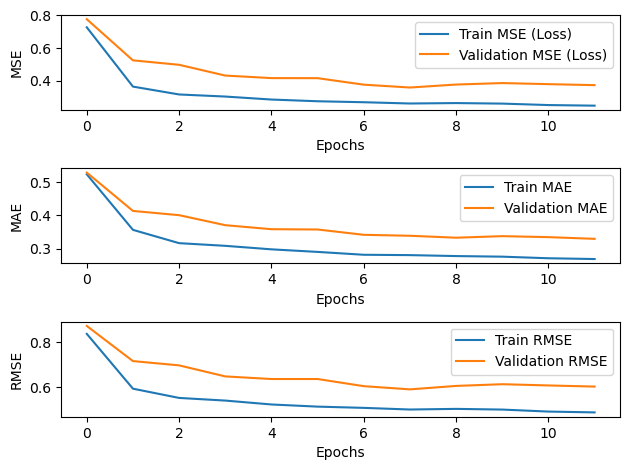

6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.3911 - mean_absolute_error: 0.3238 - root_mean_squared_error: 0.6103


In [7]:
# LSTM model
lstm_es_callback = tf.keras.callbacks.EarlyStopping(
    monitor="val_loss",
    min_delta=0,
    patience=4,
    verbose=1,
    restore_best_weights=True
)


continuous_input = Input(
    shape=continuous_train_inputs.shape[1:], 
    name="continuous_input"
)

categorical_input = Input(
    shape=categorical_train_inputs.shape[1:], 
    name="categorical_input"
)

noisy_input = GaussianNoise(stddev=0.3)(continuous_input)
combined_inputs = Concatenate(axis=-1)([noisy_input, categorical_input])
reshaped = Reshape(target_shape=(-1, combined_inputs.shape[3]))(combined_inputs)
lstm = LSTM(8, kernel_regularizer=tf.keras.regularizers.l2(0.002))(reshaped)
dropout = Dropout(0.2)(lstm)
dense = Dense(train_targets.shape[1] * train_targets.shape[2])(dropout)
outputs = Reshape(target_shape=(train_targets.shape[1], train_targets.shape[2]))(dense)

lstm_model = Model(inputs=[continuous_input, categorical_input], outputs=outputs)

lstm_model.compile(
    loss='mean_squared_error', 
    metrics=['root_mean_squared_error', 'mean_absolute_error'], 
    optimizer=tf.keras.optimizers.Adam(0.002)
)

print(lstm_model.summary())


history = lstm_model.fit(
    [continuous_train_inputs, categorical_train_inputs], 
    train_targets, 
    validation_data=([continuous_test_inputs, categorical_test_inputs], test_targets), 
    epochs=50, 
    batch_size=10, 
    callbacks=[lstm_es_callback]
)

fig, axs = plt.subplots(3)
axs[0].plot(history.history['loss'], label='Train MSE (Loss)')
axs[0].plot(history.history['val_loss'], label='Validation MSE (Loss)')
axs[1].plot(history.history['mean_absolute_error'], label='Train MAE')
axs[1].plot(history.history['val_mean_absolute_error'], label='Validation MAE')
axs[2].plot(history.history['root_mean_squared_error'], label='Train RMSE')
axs[2].plot(history.history['val_root_mean_squared_error'], label='Validation RMSE')

axs[0].set_xlabel('Epochs')
axs[0].set_ylabel('MSE')
axs[1].set_xlabel('Epochs')
axs[1].set_ylabel('MAE')
axs[2].set_xlabel('Epochs')
axs[2].set_ylabel('RMSE')
axs[0].legend()
axs[1].legend()
axs[2].legend()
fig.tight_layout()
plt.show()

eval = lstm_model.evaluate([continuous_val_inputs, categorical_val_inputs], val_targets)

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ continuous_input    │ (None, 54, 7, 3)  │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ gaussian_noise_2    │ (None, 54, 7, 3)  │          0 │ continuous_input… │
│ (GaussianNoise)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ categorical_input   │ (None, 54, 7, 15) │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_2       │ (None, 54, 7, 18) │          0 │ gaussian_noise_2… │
│ (Concatenate)       │                   │            │ categorical_inpu… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ reshape_3 (Reshape) │ (None, 378, 18)   │          0 │ concatenate_2[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d (Conv1D)     │ (None, 378, 32)   │      1,760 │ reshape_3[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling1d       │ (None, 189, 32)   │          0 │ conv1d[0][0]      │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_1 (Dropout) │ (None, 189, 32)   │          0 │ max_pooling1d[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ gru (GRU)           │ (None, 8)         │      1,008 │ dropout_1[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_2 (Dropout) │ (None, 8)         │          0 │ gru[0][0]         │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 54)        │        486 │ dropout_2[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ reshape_4 (Reshape) │ (None, 54, 1)     │          0 │ dense_1[0][0]     │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 3,254 (12.71 KB)

 Trainable params: 3,254 (12.71 KB)

 Non-trainable params: 0 (0.00 B)

None
Epoch 1/50
134/134 ━━━━━━━━━━━━━━━━━━━━ 6s 33ms/step - loss: 0.8519 - mean_absolute_error: 0.5745 - root_mean_squared_error: 0.8777 - val_loss: 0.6959 - val_mean_absolute_error: 0.4832 - val_root_mean_squared_error: 0.8196
Epoch 2/50
134/134 ━━━━━━━━━━━━━━━━━━━━ 4s 32ms/step - loss: 0.3772 - mean_absolute_error: 0.3577 - root_mean_squared_error: 0.5974 - val_loss: 0.4729 - val_mean_absolute_error: 0.3950 - val_root_mean_squared_error: 0.6788
Epoch 3/50
134/134 ━━━━━━━━━━━━━━━━━━━━ 4s 32ms/step - loss: 0.2618 - mean_absolute_error: 0.2988 - root_mean_squared_error: 0.4992 - val_loss: 0.4175 - val_mean_absolute_error: 0.3674 - val_root_mean_squared_error: 0.6391
Epoch 4/50
134/134 ━━━━━━━━━━━━━━━━━━━━ 4s 31ms/step - loss: 0.2953 - mean_absolute_error: 0.2903 - root_mean_squared_error: 0.5271 - val_loss: 0.3727 - val_mean_absolute_error: 0.3529 - val_root_mean_squared_error: 0.6039
Epoch 5/50
134/134 ━━━━━━━━━━━━━━━━━━━━ 4s 32ms/step - loss: 0.2280 - mean_absolute_error: 0.2681 - roo

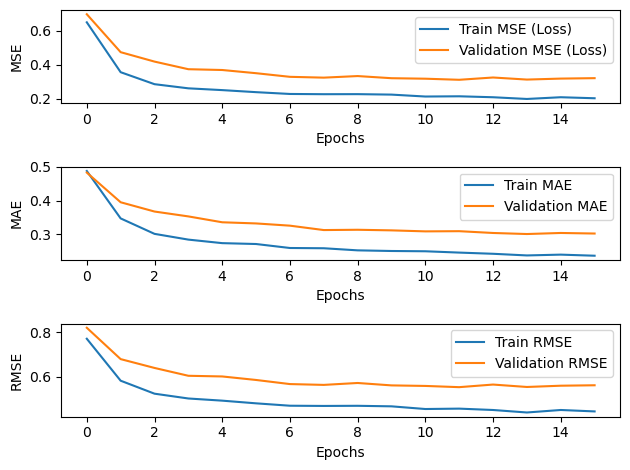

6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.3537 - mean_absolute_error: 0.2936 - root_mean_squared_error: 0.5820


In [10]:
# CNN-GRU model
gru_es_callback = tf.keras.callbacks.EarlyStopping(
    monitor="val_loss",
    min_delta=0,
    patience=4,
    verbose=1,
    restore_best_weights=True
)


continuous_input = Input(
    shape=continuous_train_inputs.shape[1:], 
    name="continuous_input"
)

categorical_input = Input(
    shape=categorical_train_inputs.shape[1:], 
    name="categorical_input"
)

noisy_input = GaussianNoise(stddev=0.3)(continuous_input)
combined_inputs = Concatenate(axis=-1)([noisy_input, categorical_input])
reshaped = Reshape(target_shape=(-1, combined_inputs.shape[3]))(combined_inputs)
conv = Conv1D(filters=32, kernel_size=3, activation='relu', padding='same')(reshaped)
pooled = MaxPooling1D(pool_size=2)(conv)
dropout1 = Dropout(0.1)(pooled)
gru = GRU(8, kernel_regularizer=tf.keras.regularizers.l2(0.004))(dropout1)
dropout2 = Dropout(0.2)(gru)
dense = Dense(train_targets.shape[1] * train_targets.shape[2])(dropout2)
outputs = Reshape(target_shape=(train_targets.shape[1], train_targets.shape[2]))(dense)

gru_model = Model(inputs=[continuous_input, categorical_input], outputs=outputs)

gru_model.compile(
    loss='mean_squared_error', 
    metrics=['root_mean_squared_error', 'mean_absolute_error'], 
    optimizer=tf.keras.optimizers.Adam(0.002)
)

print(gru_model.summary())


history = gru_model.fit(
    [continuous_train_inputs, categorical_train_inputs], 
    train_targets, 
    validation_data=([continuous_test_inputs, categorical_test_inputs], test_targets), 
    epochs=50, 
    batch_size=10, 
    callbacks=[gru_es_callback]
)

fig, axs = plt.subplots(3)
axs[0].plot(history.history['loss'], label='Train MSE (Loss)')
axs[0].plot(history.history['val_loss'], label='Validation MSE (Loss)')
axs[1].plot(history.history['mean_absolute_error'], label='Train MAE')
axs[1].plot(history.history['val_mean_absolute_error'], label='Validation MAE')
axs[2].plot(history.history['root_mean_squared_error'], label='Train RMSE')
axs[2].plot(history.history['val_root_mean_squared_error'], label='Validation RMSE')

axs[0].set_xlabel('Epochs')
axs[0].set_ylabel('MSE')
axs[1].set_xlabel('Epochs')
axs[1].set_ylabel('MAE')
axs[2].set_xlabel('Epochs')
axs[2].set_ylabel('RMSE')
axs[0].legend()
axs[1].legend()
axs[2].legend()
fig.tight_layout()
plt.show()

eval = gru_model.evaluate([continuous_val_inputs, categorical_val_inputs], val_targets)

In [11]:
# Generate predicitons for the validation set
predictions = gru_model.predict([continuous_val_inputs, categorical_val_inputs])

# Denormalize to the original scale of the data
targets_denormalized = val_targets * global_stddev[0] + global_mean[0]
predictions_denormalized = predictions * global_stddev[0] + global_mean[0]

targets_flat = targets_denormalized.flatten()
predictions_flat = predictions_denormalized.flatten()

# Join the predictions and actual sales values for each store/date into a dataframe
n = predictions_denormalized.shape[0]
store_numbers = list(range(54)) * n
predictions_df = pd.DataFrame({'store_nbr': store_numbers, 'actual_sales': targets_flat, 'predicted_sales': predictions_flat})

# View a random sample of 20 predicted vs actual sales values
display(predictions_df.sample(20))

# Compute RMSE and MAE on the original scale
rmse = root_mean_squared_error(targets_flat, predictions_flat)
mae = mean_absolute_error(targets_flat, predictions_flat)
print(f"RMSE: {rmse} MAE: {mae}")

6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


store_nbr  actual_sales  predicted_sales
8180         26      16046.30     17907.822266
3862         28      10895.02     10753.710938
5308         16      17277.80     12901.463867
1958         14       7880.67      8204.811523
6845         41      11103.59      9525.727539
1551         39      18448.76     13525.767578
335          11       8345.61      7517.866211
1122         42      14172.64     11241.218750
8110         10      24994.33     19187.845703
8238         30      20283.76     16605.695312
3956         14       7642.40      8318.297852
7020          0       9871.20      9582.510742
8249         41      12421.93     10224.579102
6332         14       8207.75      8864.829102
7529         23      14949.96     18694.332031
6388         16      32757.37     13801.833984
3581         17       7477.90      9990.966797
8717         23      15866.39     17019.837891
7210         28      12984.29     10503.145508
5118         42      11932.66     11329.074219

RMSE: 6487.295948014206 MAE: 3067.512232191019


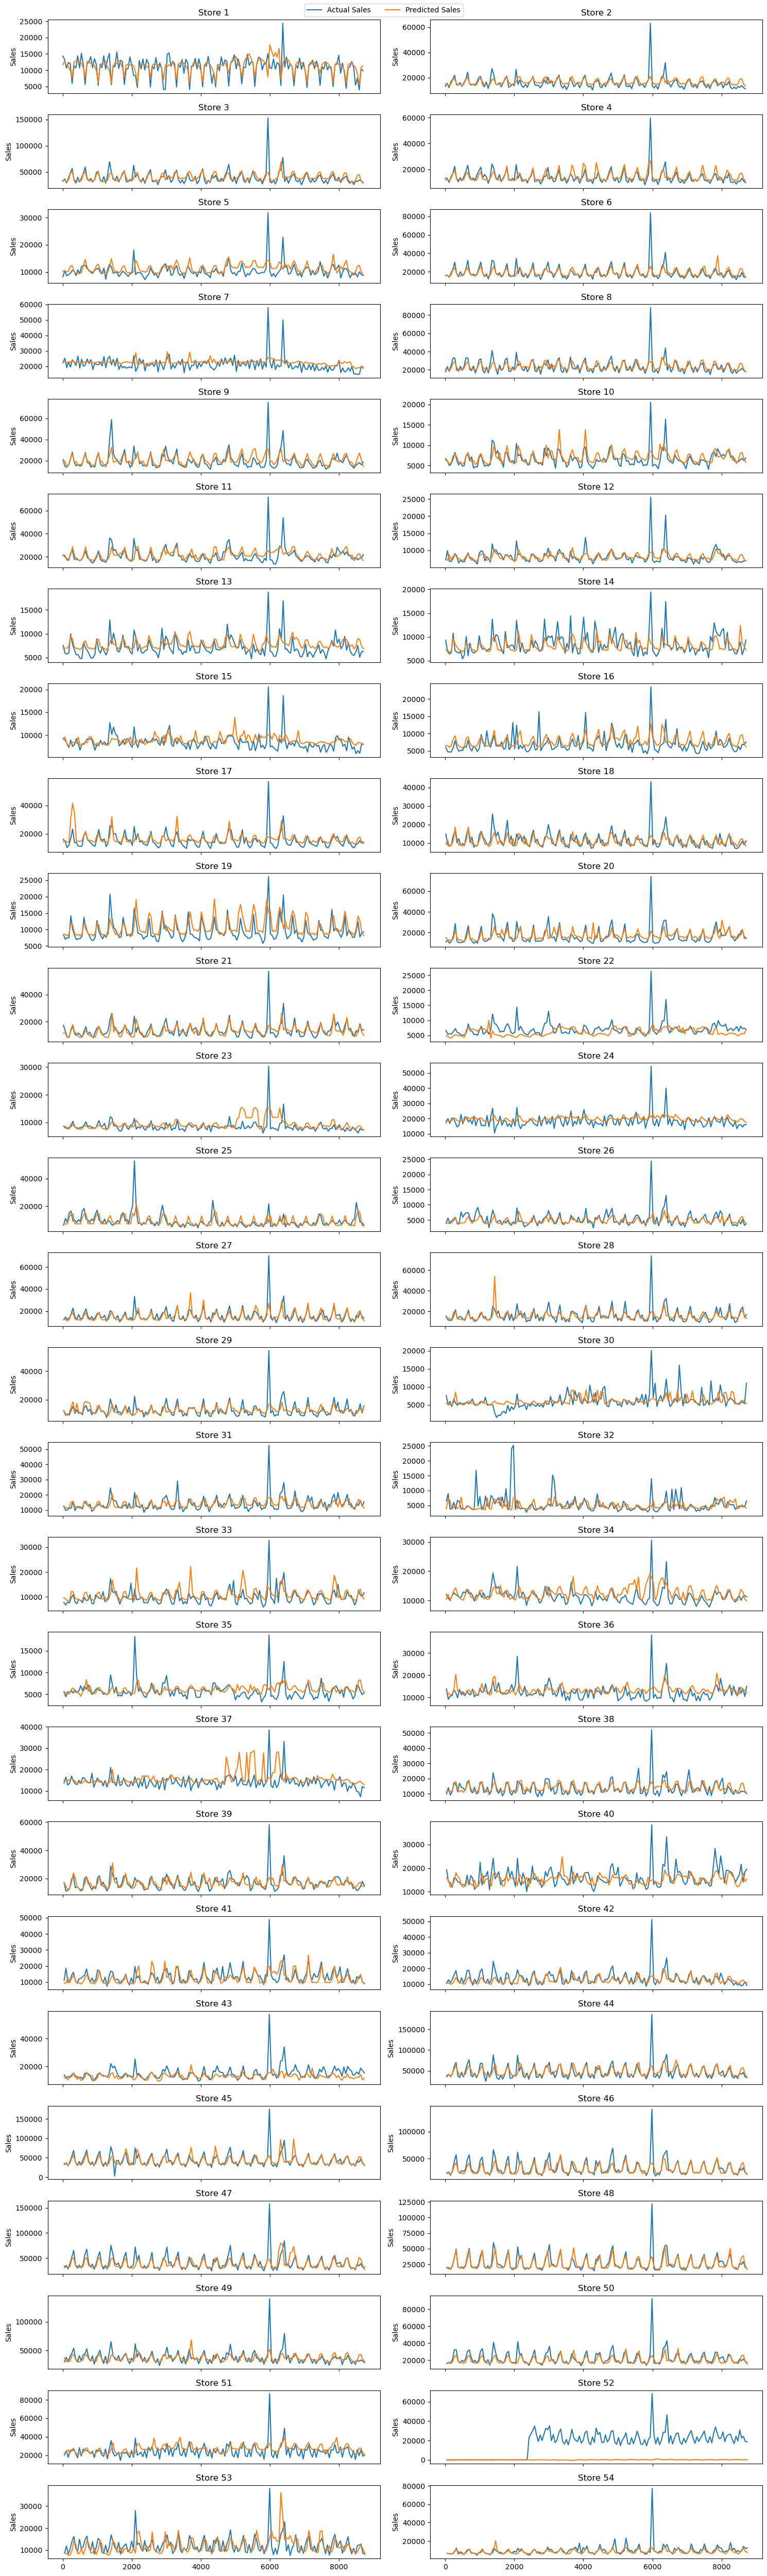

In [45]:
fig, axs = plt.subplots(27, 2, figsize=(15, 50), sharex=True)
axs = axs.ravel()
for i in range(54):
    ax = axs[i]
    store_data = predictions_df[predictions_df["store_nbr"] == i]

    ax.plot(store_data.index, store_data['actual_sales'], label='Actual Sales')
    ax.plot(store_data.index, store_data['predicted_sales'], label='Predicted Sales')

    ax.set_title(f"Store {i+1}")
    ax.set_ylabel("Sales")

fig.legend(['Actual Sales', 'Predicted Sales'], loc='upper center', ncol=2)
plt.tight_layout()
plt.show()

## Experiment: Train a model on the residuals for each store

In [15]:
!pip install xgboost

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 153.9/153.9 MB 8.4 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 199.0/199.0 MB 5.8 MB/s eta 0:00:00:00:0100:01


In [16]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import AdaBoostRegressor
from sklearn.ensemble import HistGradientBoostingRegressor
from xgboost import XGBRegressor

In [17]:
# Generate predictions from the training set and calculate residuals (error) 
train_predictions = gru_model.predict([continuous_train_inputs, categorical_train_inputs])
train_residuals = train_targets - train_predictions

lag_continuous_features = continuous_train_inputs[:, :, -1, :]
rolling_mean_continuous_features = np.mean(continuous_train_inputs, axis=2)
rolling_std_continuous_features = np.std(continuous_train_inputs, axis=2)
latest_categorical_features = categorical_train_inputs[:, :, -1, :]

combined_train_features = np.concatenate(
    [lag_continuous_features, rolling_mean_continuous_features, 
     rolling_std_continuous_features, latest_categorical_features], axis=-1
)

# # Join the inputs back together
# train_inputs = np.concatenate((continuous_train_inputs, categorical_train_inputs), axis=-1)
# print(train_inputs.shape)

# # Aggregate the days in each window
# aggregated_train_inputs = np.mean(train_inputs, axis=2)

print(train_predictions.shape)
print(train_residuals.shape)
print(combined_train_features.shape)

42/42 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step
(1340, 54, 1)
(1340, 54, 1)
(1340, 54, 24)


In [18]:
# For each store, train a random forest regressor on the residuals
store_residual_models = {}
n_estimators_per_tree = 10

for i in range(54):
    store_train_inputs = combined_train_features[:, i, :]
    store_train_residuals = train_residuals[:, i]

    #store_residual_model = RandomForestRegressor(n_estimators=n_estimators_per_tree)
    #store_residual_model = GradientBoostingRegressor(loss='absolute_error', n_estimators=n_estimators_per_tree, learning_rate=0.0001)
    #store_residual_model = DecisionTreeRegressor()
    store_residual_model = AdaBoostRegressor(n_estimators=n_estimators_per_tree, loss='square', learning_rate=0.5)
    #store_residual_model = HistGradientBoostingRegressor(learning_rate=0.2)
    #store_residual_model = XGBRegressor(n_estimators=n_estimators_per_tree, early_stopping_rounds=10, learning_rate=0.1, gamma=0.1)
    #store_residual_model = XGBRegressor(n_estimators=n_estimators_per_tree)
    store_residual_model.fit(store_train_inputs, store_train_residuals.squeeze())#, eval_set=[(store_train_inputs, store_train_residuals)], verbose=0)

    store_residual_models[i] = store_residual_model


store_residual_models[0]

AdaBoostRegressor(learning_rate=0.5, loss='square', n_estimators=10)

In [19]:
# Generate predictions and residuals for the validation set
val_predictions = gru_model.predict([continuous_val_inputs, categorical_val_inputs])
val_residuals = val_targets - val_predictions

# # Join the inputs back together
# val_inputs = np.concatenate((continuous_val_inputs, categorical_val_inputs), axis=-1)
# print(val_inputs.shape)

# # Aggregate across days
# aggregated_val_inputs = np.mean(val_inputs, axis=2)

# print(val_predictions.shape)
# print(val_residuals.shape)
# print(aggregated_val_inputs.shape)

lag_continuous_features = continuous_val_inputs[:, :, -1, :]
rolling_mean_continuous_features = np.mean(continuous_val_inputs, axis=2)
rolling_std_continuous_features = np.std(continuous_val_inputs, axis=2)
latest_categorical_features = categorical_val_inputs[:, :, -1, :]

combined_val_features = np.concatenate(
    [lag_continuous_features, rolling_mean_continuous_features, 
     rolling_std_continuous_features, latest_categorical_features], axis=-1
)

# Set a placeholder for the residual tree predictions
residual_model_predictions = np.zeros((val_residuals.shape[0], val_residuals.shape[1]))

# For each store, use the tree trained on the errors for that store to correct model predictions
for i in range(54):
    store_val_inputs = combined_val_features[:, i, :]
    store_predictions = store_residual_models[i].predict(store_val_inputs)
    residual_model_predictions[:, i] = store_predictions

print(residual_model_predictions.shape)

# Correct the original model predictions
ensemble_predictions = val_predictions.squeeze() + residual_model_predictions

# Denormalize the true targets and predictions
val_targets_denormalized = val_targets * global_stddev[0] + global_mean[0]
ensemble_predictions_denormalized = ensemble_predictions * global_stddev[0] + global_mean[0]

6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
(162, 54)


In [20]:
val_targets_flat = val_targets_denormalized.flatten()
ensemble_predictions_flat = ensemble_predictions_denormalized.flatten()

# Join the predictions and actual sales values for each store/date into a dataframe
n = ensemble_predictions_denormalized.shape[0]
store_numbers = list(range(54)) * n
predictions_df = pd.DataFrame({'store_nbr': store_numbers, 'actual_sales': val_targets_flat, 'predicted_sales': ensemble_predictions_flat})

# View a random sample of 20 predicted vs actual sales values
display(predictions_df.sample(20))

# Compute RMSE and MAE on the original scale
rmse = root_mean_squared_error(val_targets_flat, ensemble_predictions_flat)
mae = mean_absolute_error(val_targets_flat, ensemble_predictions_flat)
print(f"RMSE: {rmse} MAE: {mae}")

store_nbr  actual_sales  predicted_sales
7519         13       7635.98      8292.750795
680          32       8618.10     11966.171214
4442         14       6983.68      8461.494747
6196         40       9582.66     14982.526772
5279         41      13175.38     12895.944627
6341         23      20625.77     22778.419970
8483          5      15775.92     17188.362113
5317         25       3176.93      3995.946708
6645          3      15074.19     16904.700370
498          12       4833.19      6651.342835
606          12       8112.32      8221.776024
4866          6      25154.82     23265.096354
6680         38      20679.52     18478.872564
6996         30      10858.37     12082.652887
2062         10      35863.51     17884.812250
6993         27      11330.10     12802.975563
1079         53      10368.37     11492.992137
1167         33      10811.62     10893.071672
3335         41      18961.31     20728.806998
3450         48      27210.47     35500.857943

RMSE: 6461.5674191858425 MAE: 3100.1002189281726


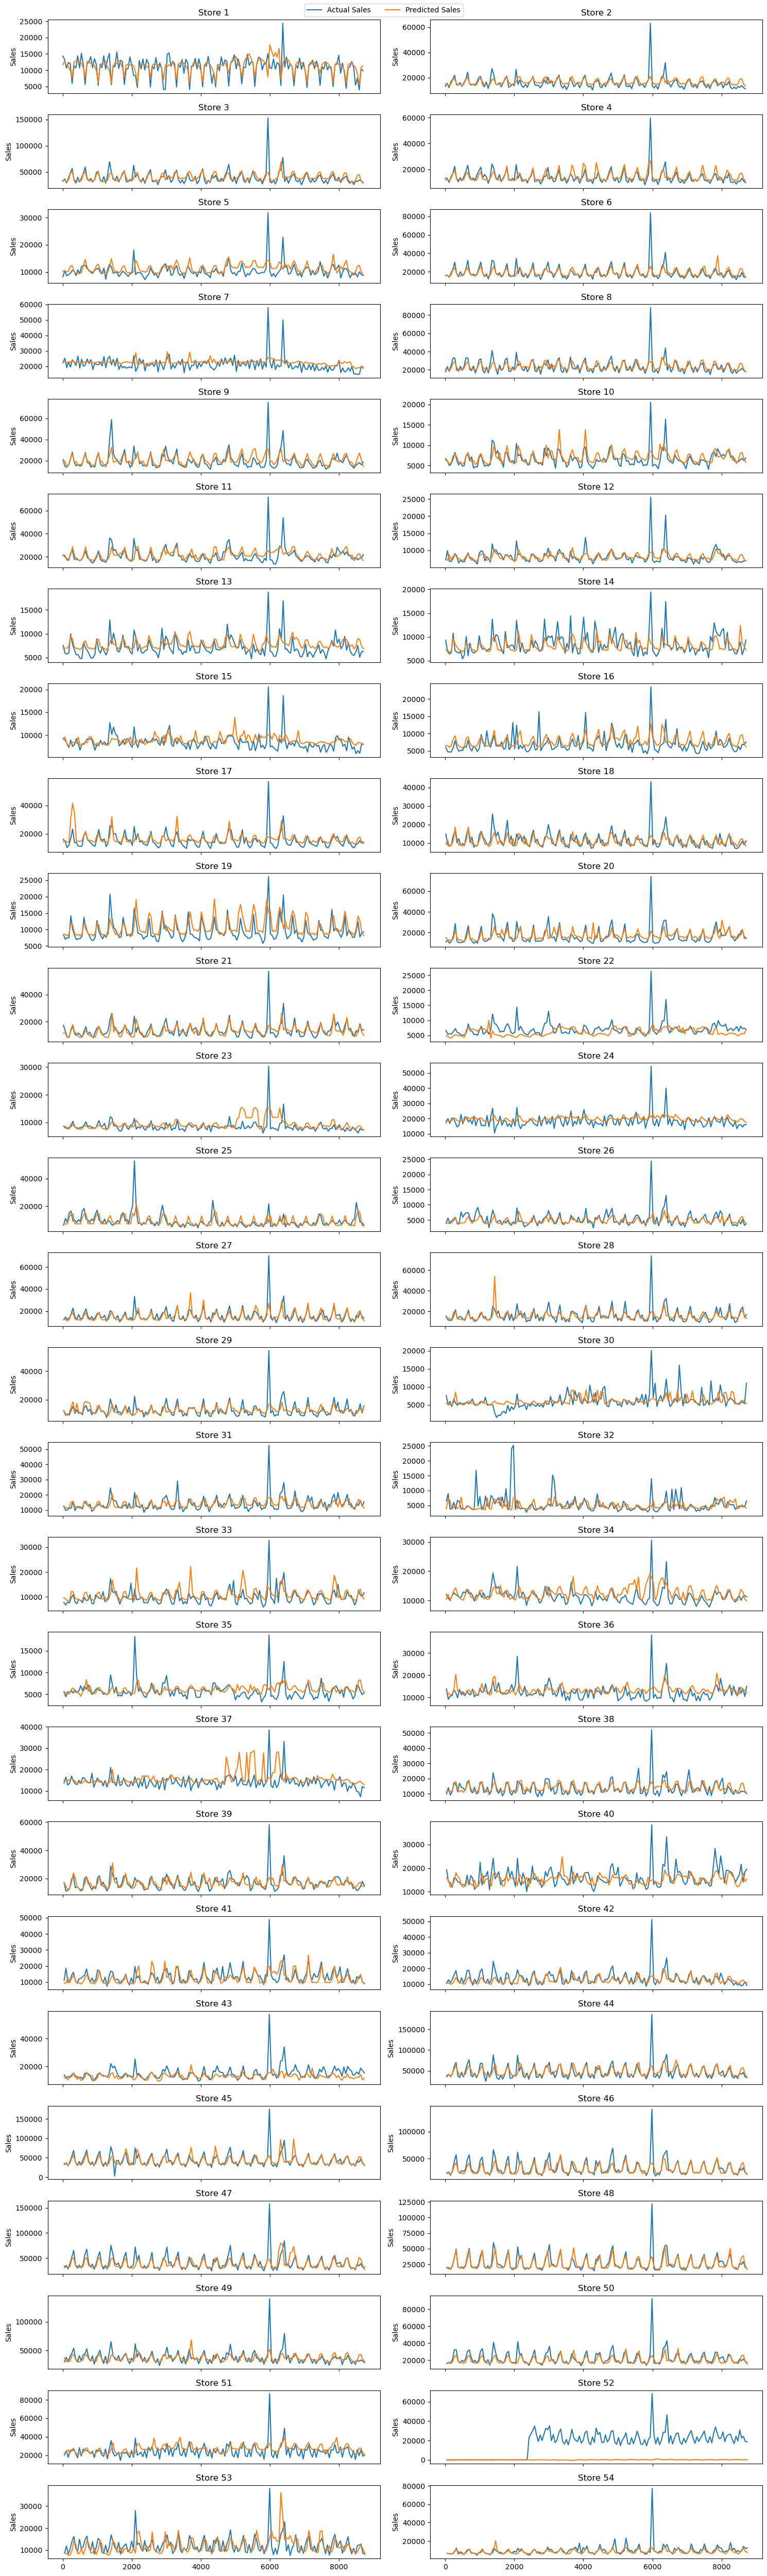

In [21]:
fig, axs = plt.subplots(27, 2, figsize=(15, 50), sharex=True)
axs = axs.ravel()
for i in range(54):
    ax = axs[i]
    store_data = predictions_df[predictions_df["store_nbr"] == i]

    ax.plot(store_data.index, store_data['actual_sales'], label='Actual Sales')
    ax.plot(store_data.index, store_data['predicted_sales'], label='Predicted Sales')

    ax.set_title(f"Store {i+1}")
    ax.set_ylabel("Sales")

fig.legend(['Actual Sales', 'Predicted Sales'], loc='upper center', ncol=2)
plt.tight_layout()
plt.show()

## Estimator

In [56]:
# Test regex for metrics
import re

metric_definitions=[
    {'Name': 'loss', 'Regex': "loss: ([0-9]+(.|e\-)[0-9]+),?"},
    {'Name': 'root_mean_squared_error', 'Regex': "root_mean_squared_error: ([0-9]+(.|e\-)[0-9]+),?"},
    {'Name': 'mean_absolute_error', 'Regex': "mean_absolute_error: ([0-9]+(.|e\-)[0-9]+),?"},
    {'Name': 'val_loss', 'Regex': "val_loss: ([0-9]+(.|e\-)[0-9]+),?"},
    {'Name': 'val_root_mean_squared_error', 'Regex': "val_root_mean_squared_error: ([0-9]+(.|e\-)[0-9]+),?"},
    {'Name': 'val_mean_absolute_error', 'Regex': "val_mean_absolute_error: ([0-9]+(.|e\-)[0-9]+),?"},
    {'Name': 'epoch', 'Regex': "Epoch ([0-9]+(.|e\-)[0-9]+),?"}]

txt = "Epoch 134/134 - 11s - loss: 0.3353 - root_mean_squared_error: 0.5661 - mean_absolute_error: 0.3318 - val_loss: 0.4673 - val_root_mean_squared_error: 0.6754 - val_mean_absolute_error: 0.3939"
for metric in metric_definitions:
    for name, regex in metric.items():
        if name == "Regex":
            print(regex)
            print(re.search(regex, txt))


loss: ([0-9]+(.|e\-)[0-9]+),?
<re.Match object; span=(22, 34), match='loss: 0.3353'>
root_mean_squared_error: ([0-9]+(.|e\-)[0-9]+),?
<re.Match object; span=(37, 68), match='root_mean_squared_error: 0.5661'>
mean_absolute_error: ([0-9]+(.|e\-)[0-9]+),?
<re.Match object; span=(71, 98), match='mean_absolute_error: 0.3318'>
val_loss: ([0-9]+(.|e\-)[0-9]+),?
<re.Match object; span=(101, 117), match='val_loss: 0.4673'>
val_root_mean_squared_error: ([0-9]+(.|e\-)[0-9]+),?
<re.Match object; span=(120, 155), match='val_root_mean_squared_error: 0.6754'>
val_mean_absolute_error: ([0-9]+(.|e\-)[0-9]+),?
<re.Match object; span=(158, 189), match='val_mean_absolute_error: 0.3939'>
Epoch ([0-9]+(.|e\-)[0-9]+),?
<re.Match object; span=(0, 13), match='Epoch 134/134'>


In [57]:
metric_definitions=[
    {'Name': 'loss', 'Regex': "loss: ([0-9]+(.|e\-)[0-9]+),?"},
    {'Name': 'root_mean_squared_error', 'Regex': "root_mean_squared_error: ([0-9]+(.|e\-)[0-9]+),?"},
    {'Name': 'mean_absolute_error', 'Regex': "mean_absolute_error: ([0-9]+(.|e\-)[0-9]+),?"},
    {'Name': 'val_loss', 'Regex': "val_loss: ([0-9]+(.|e\-)[0-9]+),?"},
    {'Name': 'val_root_mean_squared_error', 'Regex': "val_root_mean_squared_error: ([0-9]+(.|e\-)[0-9]+),?"},
    {'Name': 'val_mean_absolute_error', 'Regex': "val_mean_absolute_error: ([0-9]+(.|e\-)[0-9]+),?"},
    {'Name': 'epoch', 'Regex': "Epoch ([0-9]+(.|e\-)[0-9]+),?"}]

estimator = TensorFlow(
    entry_point='train.py',
    role=role,
    instance_count=1,
    instance_type='ml.m5.xlarge',
    framework_version='2.6',
    py_version='py38',
    hyperparameters={
        'batch_size': 10,
        'epochs': 50,
        'learning_rate': 0.002,
        'noise': 0.3,
        'l2_regularization': 0.004,
        'dropout': 0.1
    },
    metric_definitions=metric_definitions,
    output_path=f's3://{sagemaker_session.default_bucket()}/store-sales-forecasting/training-output/'
)

estimator.fit({
    'train': f"s3://{sagemaker_session.default_bucket()}/{train_prefix}", 
    'test':  f"s3://{sagemaker_session.default_bucket()}/{test_prefix}", 
    'validation':  f"s3://{sagemaker_session.default_bucket()}/{val_prefix}"
})

INFO:sagemaker.image_uris:image_uri is not presented, retrieving image_uri based on instance_type, framework etc.
INFO:sagemaker.image_uris:image_uri is not presented, retrieving image_uri based on instance_type, framework etc.
INFO:sagemaker:Creating training-job with name: tensorflow-training-2024-10-14-17-24-47-859


2024-10-14 17:24:48 Starting - Starting the training job...
2024-10-14 17:25:05 Starting - Preparing the instances for training...
2024-10-14 17:25:26 Downloading - Downloading input data...
2024-10-14 17:25:52 Downloading - Downloading the training image...
2024-10-14 17:26:43 Training - Training image download completed. Training in progress..2024-10-14 17:26:48.530121: W tensorflow/core/profiler/internal/smprofiler_timeline.cc:460] Initializing the SageMaker Profiler.
2024-10-14 17:26:48.530291: W tensorflow/core/profiler/internal/smprofiler_timeline.cc:105] SageMaker Profiler is not enabled. The timeline writer thread will not be started, future recorded events will be dropped.
2024-10-14 17:26:48.557355: W tensorflow/core/profiler/internal/smprofiler_timeline.cc:460] Initializing the SageMaker Profiler.
2024-10-14 17:26:49,784 sagemaker-training-toolkit INFO     Imported framework sagemaker_tensorflow_container.training
2024-10-14 17:26:49,793 sagemaker-training-toolkit INFO     N

In [61]:
# Print S3 path where model was saved
sm_client = boto3.client('sagemaker', region_name=region)
model_artifacts = estimator.latest_training_job.describe()["ModelArtifacts"]["S3ModelArtifacts"]
print(f"Model artifacts saved at: {model_artifacts}")

Model artifacts saved at: s3://sagemaker-us-east-1-342408968837/store-sales-forecasting/training-output/tensorflow-training-2024-10-14-17-24-47-859/output/model.tar.gz


In [63]:
# sm_client.delete_model(ModelName='store-sales-forecasting-custom-model')

{'ResponseMetadata': {'RequestId': 'b0237bb7-2988-461c-8d88-c5e0d225875c',
  'HTTPStatusCode': 200,
  'HTTPHeaders': {'x-amzn-requestid': 'b0237bb7-2988-461c-8d88-c5e0d225875c',
   'content-type': 'application/x-amz-json-1.1',
   'date': 'Mon, 14 Oct 2024 17:37:41 GMT',
   'content-length': '0'},
  'RetryAttempts': 0}}

In [64]:
# Create a model from the last training job
model_name = "store-sales-forecasting-custom-model"
model = estimator.create_model(name=model_name)
model_container = model.prepare_container_def(instance_type='ml.m5.xlarge')

print(model_container)

sagemaker_session.create_model(model_name, role, model_container)

INFO:sagemaker.tensorflow.model:image_uri is not presented, retrieving image_uri based on instance_type, framework etc.
INFO:sagemaker:Creating model with name: store-sales-forecasting-custom-model


{'Image': '763104351884.dkr.ecr.us-east-1.amazonaws.com/tensorflow-inference:2.6-cpu', 'Environment': {'SAGEMAKER_TFS_NGINX_LOGLEVEL': 'info'}, 'ModelDataUrl': 's3://sagemaker-us-east-1-342408968837/store-sales-forecasting/training-output/tensorflow-training-2024-10-14-17-24-47-859/output/model.tar.gz'}


'store-sales-forecasting-custom-model'

In [65]:
# Define and create model group
model_package_group_name = "store-sales-forecasting-custom-model-group"
model_package_group_input_dict = {
 "ModelPackageGroupName" : model_package_group_name,
 "ModelPackageGroupDescription" : "This model group contains time series forecasting models for predicting store sales for 54 Favorita stores."
}

create_model_package_group_response = sm_client.create_model_package_group(**model_package_group_input_dict)
print('ModelPackageGroup Arn : {}'.format(create_model_package_group_response['ModelPackageGroupArn']))

ModelPackageGroup Arn : arn:aws:sagemaker:us-east-1:342408968837:model-package-group/store-sales-forecasting-custom-model-group


In [66]:
# Check that the model group was created
describe_model_package_group_response = sm_client.describe_model_package_group(ModelPackageGroupName=model_package_group_name)
describe_model_package_group_response 

{'ModelPackageGroupName': 'store-sales-forecasting-custom-model-group',
 'ModelPackageGroupArn': 'arn:aws:sagemaker:us-east-1:342408968837:model-package-group/store-sales-forecasting-custom-model-group',
 'ModelPackageGroupDescription': 'This model group contains time series forecasting models for predicting store sales for 54 Favorita stores.',
 'CreationTime': datetime.datetime(2024, 10, 14, 17, 37, 58, 424000, tzinfo=tzlocal()),
 'CreatedBy': {'UserProfileArn': 'arn:aws:sagemaker:us-east-1:342408968837:user-profile/d-2cr7fbmrqyrg/jlawton',
  'UserProfileName': 'jlawton',
  'DomainId': 'd-2cr7fbmrqyrg',
  'IamIdentity': {'Arn': 'arn:aws:sts::342408968837:assumed-role/LabRole/SageMaker',
   'PrincipalId': 'AROAU7OJKHKCWCCLLHI6O:SageMaker'}},
 'ModelPackageGroupStatus': 'Completed',
 'ResponseMetadata': {'RequestId': '932b6f65-a25e-4881-a37c-4405b6bd6fb2',
  'HTTPStatusCode': 200,
  'HTTPHeaders': {'x-amzn-requestid': '932b6f65-a25e-4881-a37c-4405b6bd6fb2',
   'content-type': 'applicat

In [67]:
# Specify the model container
modelpackage_inference_specification =  {
    "InferenceSpecification": {
        "Containers": [model_container],
        "SupportedContentTypes": [ "text/csv" ],
        "SupportedResponseMIMETypes": [ "text/csv" ],
      
    }
 }

# Specify package details
create_model_package_input_dict = {
    "ModelPackageGroupName" : model_package_group_name,
    "ModelPackageDescription" : "Custom store sales forecasting model using CNN-GRU architecture",
    "ModelApprovalStatus" : "PendingManualApproval"
}
create_model_package_input_dict.update(modelpackage_inference_specification)

In [68]:
# Create the model package
create_model_package_response = sm_client.create_model_package(**create_model_package_input_dict)
model_package_arn = create_model_package_response["ModelPackageArn"]
print('ModelPackage Version ARN : {}'.format(model_package_arn))

ModelPackage Version ARN : arn:aws:sagemaker:us-east-1:342408968837:model-package/store-sales-forecasting-custom-model-group/1


In [69]:
# Check that the model package was created
describe_model_package_response = sm_client.describe_model_package(ModelPackageName=model_package_arn)
describe_model_package_response

{'ModelPackageGroupName': 'store-sales-forecasting-custom-model-group',
 'ModelPackageVersion': 1,
 'ModelPackageArn': 'arn:aws:sagemaker:us-east-1:342408968837:model-package/store-sales-forecasting-custom-model-group/1',
 'ModelPackageDescription': 'Custom store sales forecasting model using CNN-GRU architecture',
 'CreationTime': datetime.datetime(2024, 10, 14, 17, 38, 7, 363000, tzinfo=tzlocal()),
 'InferenceSpecification': {'Containers': [{'Image': '763104351884.dkr.ecr.us-east-1.amazonaws.com/tensorflow-inference:2.6-cpu',
    'ImageDigest': 'sha256:de3fd33aa1fa3225474fced65a5ed5bdcdce841319b517697d080b37ff5bacce',
    'ModelDataUrl': 's3://sagemaker-us-east-1-342408968837/store-sales-forecasting/training-output/tensorflow-training-2024-10-14-17-24-47-859/output/model.tar.gz',
    'Environment': {'SAGEMAKER_TFS_NGINX_LOGLEVEL': 'info'}}],
  'SupportedContentTypes': ['text/csv'],
  'SupportedResponseMIMETypes': ['text/csv']},
 'ModelPackageStatus': 'Completed',
 'ModelPackageStatus

In [70]:
# Define model overview
model_overview = ModelOverview.from_model_name(
    model_name=model_name,
    sagemaker_session=sagemaker_session,
    model_description="Model to predict store sales for 54 Favorita stores based on historical sales data, oil prices, and seasonal information.",
    problem_type="Time Series Forecasting",
    algorithm_type="CNN-GRU",
    model_creator="AAI 540 Team 5",
    model_owner="AAI 540 Team 5",
)

In [72]:
# Define objective funtion
objective_function = ObjectiveFunction(
    function=Function(
        function=ObjectiveFunctionEnum.MINIMIZE,
        facet=FacetEnum.LOSS,
    ),
    notes="The model optimizes for mean squared error during training.",
)

# Get hyperparameters from the training job
job = sm_client.describe_training_job(TrainingJobName=estimator.latest_training_job.name)
hyperparameters = [HyperParameter(key, value) for key, value in job['HyperParameters'].items()]

# Create job details to include the hyperparameters in the training details
training_job_details = TrainingJobDetails(
    hyper_parameters=hyperparameters
)

# Define and view training details
training_details = TrainingDetails.from_model_overview(
    model_overview=model_overview,
    sagemaker_session=sagemaker_session,
    objective_function=objective_function,
    training_job_details=training_job_details
)
print(f"Training job id: {training_details.training_job_details.training_arn}")
print(
    f"Training image: {training_details.training_job_details.training_environment.container_image}"
)
print("Training Metrics: ")
print(
    [
        {"name": i.name, "value": i.value}
        for i in training_details.training_job_details.training_metrics
    ]
)

Training job id: arn:aws:sagemaker:us-east-1:342408968837:training-job/tensorflow-training-2024-10-14-17-24-47-859
Training image: ['763104351884.dkr.ecr.us-east-1.amazonaws.com/tensorflow-training:2.6-cpu-py38']
Training Metrics: 
[{'name': 'loss', 'value': 0.39800000190734863}, {'name': 'root_mean_squared_error', 'value': 0.6266999840736389}, {'name': 'mean_absolute_error', 'value': 0.2879999876022339}, {'name': 'val_loss', 'value': 0.32249999046325684}, {'name': 'val_root_mean_squared_error', 'value': 0.5633999705314636}, {'name': 'val_mean_absolute_error', 'value': 0.29899999499320984}, {'name': 'epoch', 'value': 28.0}]


In [73]:
# Define intended uses and business_details
intended_uses = IntendedUses(
    purpose_of_model="This model is designed to forecast store sales for Favorita stores.",
    intended_uses="This model is intended to forecast sales for the 54 currently operational Favorita stores.",
    factors_affecting_model_efficiency="N/A",
    risk_rating=RiskRatingEnum.LOW,
    explanations_for_risk_rating="No PII or other sensitive information is used in this model.",
)
business_details = BusinessDetails(
    business_problem="Predicting Favorita store sales.",
    business_stakeholders="Favorita store managers, owners, and stakeholders.",
    line_of_business="Sales",
)

In [74]:
# Create the model card
model_card_name = f"{model_name}-model-card"
model_card = ModelCard(
    name=model_card_name,
    status=ModelCardStatusEnum.DRAFT,
    model_overview=model_overview,
    training_details=training_details,
    intended_uses=intended_uses,
    business_details=business_details,
    sagemaker_session=sagemaker_session,
)
model_card.create()
print(f"Model card {model_card.name} is successfully created with id {model_card.arn}")

INFO:sagemaker.model_card.model_card:Creating model card with name: store-sales-forecasting-custom-model-model-card


Model card store-sales-forecasting-custom-model-model-card is successfully created with id arn:aws:sagemaker:us-east-1:342408968837:model-card/store-sales-forecasting-custom-model-model-card


In [77]:
# Export the model card as a PDF and store in S3
s3_output_path = f"s3://{bucket}/store-sales-forecasting/export"
pdf_s3_url = model_card.export_pdf(s3_output_path=s3_output_path)

INFO:sagemaker.model_card.model_card:Model card store-sales-forecasting-custom-model-model-card is successfully exported to s3://sagemaker-us-east-1-342408968837/store-sales-forecasting/export/store-sales-forecasting-custom-model-model-card/store-sales-forecasting-custom-model-model-card-1728928276-e6e6.pdf.
